In [1]:
import fenics as fn
import numpy as np
#
from scipy import sparse as sp
from scipy.sparse.linalg import spsolve
#
from matplotlib import pyplot as plt
#
from copy import copy
from time import time

$$\frac{\partial}{\partial t}\begin{pmatrix} y_1 \\ y_2 \end{pmatrix} - 
\nu\begin{pmatrix}\Delta & 0 \\ 0 & \Delta\end{pmatrix} \begin{pmatrix} y_1 \\ y_2 \end{pmatrix} + \begin{pmatrix}0 & \gamma_1 \\ \gamma_2 & 0\end{pmatrix} \begin{pmatrix} y_1 \\ y_2 \end{pmatrix} = \begin{pmatrix} f_1 \\ f_2 \end{pmatrix}$$

**Parameters**

In [2]:
Ne = 100
nu = 0.1 #0.1
dt = 0.01
T  = 0.5
t_vector = np.linspace(0,T,int(T/dt)+1)
Nt = t_vector.shape[0]
#
gamma1, gamma2 = 1., 2.
#
K        = 1.2e+3 # 500 for sigma2
ALPHA    = .01
STOP_CRI = 1.e-5
OBS_DOM  = (0.2,0.4,0.6,0.8)

In [3]:
label_str = 'ex03_f1_sigma1_obs_0.2_0.4_0.6_0.8'

In [4]:
def sigma(t):
    return 1. + 0.*t
############################################################################
#def sigma(t):
#    t0 = 3*T/4
#    aux = (1 + 2*t/t0 - (t/t0)**2)*(t < t0) + (2. + t*0)*(t >= t0)
#    return aux
############################################################################
#def sigma(t):
#    eps = T/10
#    aux = (1 + (np.cos(4*np.pi*t/(T-eps))/2))*(t < T - eps) + 3/2*(t >= T - eps)
#    return aux
############################################################################

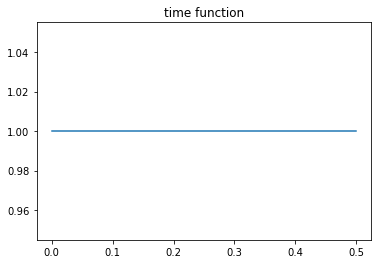

In [5]:
plt.plot(t_vector,sigma(t_vector))
plt.title('time function')
plt.show()

In [6]:
print('elements:',Ne)
print('time steps:',t_vector.shape[0])

elements: 100
time steps: 51


**Mesh and FE spaces**

In [7]:
mesh = fn.IntervalMesh(Ne,0,1)
U1   = fn.FiniteElement("CG", mesh.ufl_cell(), 1)
U2   = fn.FiniteElement("CG", mesh.ufl_cell(), 1)
Un   = fn.FunctionSpace(mesh, U1*U2)

**Trial and test functions**

In [8]:
(u1, u2) = fn.TrialFunctions(Un)
(v1, v2) = fn.TestFunctions(Un)

**Observation subdomain**

In [9]:
#
obs_1 = OBS_DOM[0]
obs_2 = OBS_DOM[1]
obs_3 = OBS_DOM[2]
obs_4 = OBS_DOM[3]
class Omega0(fn.SubDomain):
    def inside(self, x, on_boundary):
        return (fn.between(x[0], (obs_1, obs_2))) or (fn.between(x[0], (obs_3, obs_4)))
#
omega0 = Omega0()
#
domains = fn.MeshFunction("size_t", mesh, mesh.topology().dim())
domains.set_all(0)
omega0.mark(domains, 1)  
#
dx_obs = fn.Measure("dx", domain=mesh, subdomain_data=domains)
# subdomain as indicator function
#obs_dom_str = 'o1 <= x[0] && x[0] <= o2 ? 1. : 0.'
#obs_dom_exp = fn.Expression((obs_dom_str,obs_dom_str), o1=obs_1, o2=obs_2, degree=0)

**Initial conditions**

In [10]:
ini_con = fn.Expression(('0.*x[0]','0.*x[0]'), degree=2)
u_ini = fn.Function(Un)
u_ini.interpolate(ini_con)
#u0_dof = u_ini.vector()[:]

**Boundary conditions**

In [11]:
g = fn.Constant((0.,0.))
bc = fn.DirichletBC(Un, g, 'on_boundary')

In [12]:
b_forw = (u1*v1)*(fn.dx) + dt*nu*fn.dot(fn.grad(u1),fn.grad(v1))*(fn.dx) + dt*gamma1*(u2*v1)*(fn.dx) + (u2*v2)*(fn.dx) + dt*nu*fn.dot(fn.grad(u2),fn.grad(v2))*(fn.dx) + dt*gamma2*(u1*v2)*(fn.dx)
b_back = (u1*v1)*(fn.dx) + dt*nu*fn.dot(fn.grad(u1),fn.grad(v1))*(fn.dx) + dt*gamma2*(u2*v1)*(fn.dx) + (u2*v2)*(fn.dx) + dt*nu*fn.dot(fn.grad(u2),fn.grad(v2))*(fn.dx) + dt*gamma1*(u1*v2)*(fn.dx)
# Matrices assemble (Fenics structure)
B_forw = fn.assemble(b_forw)
B_back = fn.assemble(b_back)
# Include BC's
bc.apply(B_forw)
bc.apply(B_back)
# Matrices to numpy array
B_forw_np = B_forw.array()
B_back_np = B_back.array()
# Matrices to sparse structure
B_forw_sp = sp.csr_matrix(B_forw_np)
B_back_sp = sp.csr_matrix(B_back_np)

In [13]:
def coupled_forward(u0, rhs,t_vector):
    '''
    This function has a input the initial condition of the system
    u0 (as a Fenics function) and the rhs (f1,f2) as a list with the DoF
    at each time
    Return: the solution's DoF of the system for all times (and its derivative)
    '''
    # Initial condition
    u_ini = fn.Function(Un)
    u_ini.vector()[:] = u0.vector()[:]
    u01, u02 = u_ini.split()
    #
    sol_list = []
    sol_t_list = []
    #sol_list.append(u_ini.vector()[:])
    f = fn.Function(Un)
    f.vector()[:] = rhs
    f1, f2 = f.split()
    #loop
    #for idx in range(t_vector[1:].shape[0]):
    for idx in range(t_vector.shape[0]):    
        #print(idx)
        #
        L  = (dt*sigma(t_vector[idx])*f1*v1 + u01*v1)*(fn.dx) + (dt*sigma(t_vector[idx])*f2*v2 + u02*v2)*(fn.dx)
        rhs = fn.assemble(L)
        bc.apply(rhs)
        #
        u_sol = fn.Function(Un)
        # Sparse solver
        #fn.solve(b_forw==L,u_sol,bc)
        aux = spsolve(B_forw_sp,rhs[:])
        #
        u_sol.vector()[:] = aux
        u01, u02 = u_sol.split()
        #
        sol_list.append(u_sol.vector()[:])
    ######################################################    
    # here we added the time derivative
    sol_t_list.append((sol_list[0] - u_ini.vector()[:])/dt)
    for idx in range(1,t_vector.shape[0]):
        sol_t_list.append((sol_list[idx] - sol_list[idx-1])/dt)
    ######################################################        
    return sol_list, sol_t_list
def coupled_backward(y,y_t,observations,observations_t,t_vector,k=1.):
    '''
    This function has a input the final contition (at time T) 
    of the system as the DoF of a Fenics function 
    Return: the solution of the system (as a list with the DoF at each time)
    '''
    # Initial condition
    u_T = fn.Function(Un)
    u_T.vector()[:] = 0.
    u01, u02 = u_T.split()
    #
    y_out = []
    #y_out.append(u_T.vector()[:])
    #loop
    #for idx in reversed(range(t_vector[:-1].shape[0])):
    for idx in reversed(range(t_vector.shape[0])):    
        y_fn = fn.Function(Un)
        y_fn.vector()[:] = y[idx]
        y1_fn, y2_fn = y_fn.split()
        #
        y_t_fn = fn.Function(Un)
        y_t_fn.vector()[:] = y_t[idx]
        y1_t_fn, y2_t_fn = y_t_fn.split()
        #
        y_obs = fn.Function(Un)
        y_obs.vector()[:] = observations[idx]
        y1_obs, y2_obs = y_obs.split()
        #
        y_t_obs = fn.Function(Un)
        y_t_obs.vector()[:] = observations_t[idx]
        y1_t_obs, y2_t_obs = y_t_obs.split()
        #
        L  = u01*v1*(fn.dx) + u02*v2*(fn.dx) - dt*k*(y1_fn - y1_obs)*v1*(dx_obs(1)) - dt*k*(y2_fn - y2_obs)*v2*(dx_obs(1))\
                             - dt*k*(y1_t_fn - y1_t_obs)*v1*(dx_obs(1))   - dt*k*(y2_t_fn - y2_t_obs)*v2*(dx_obs(1))
                                      # - dt*k*(y1_t_fn - y1_t_obs)*v1*(dx_obs(1))   - dt*k*(y2_t_fn - y2_t_obs)*v2*(dx_obs(1))
                           #- dt*k*(y1_fn - y1_obs).dx(0)*v1*(dx_obs(1)) - dt*k*(y2_fn - y2_obs).dx(0)*v2*(dx_obs(1))#\
                     
        rhs = fn.assemble(L)
        bc.apply(rhs)
        #
        u_sol = fn.Function(Un)
        # Sparse solver
        #fn.solve(b_back==L,u_sol,bc)
        aux = spsolve(B_back_sp,rhs[:])
        #
        u_sol.vector()[:] = aux
        u01, u02 = u_sol.split()
        #
        y_out.append(u_sol.vector()[:])
    # reverse the list to get first t=0 and last t=T
    y_out = list(reversed(y_out))
    return y_out

## FORWARD PROBLEM

In [14]:
#################################################################################
f_exp = fn.Expression(('sin(2*pi*x[0])','-sin(2*pi*x[0])'), degree = 2)
#################################################################################
#f1_str = '0.1 <= x[0] && x[0] <= 0.6 ? (0.35 <= x[0] && x[0] <= 0.6 ? 8*(0.6 - x[0]) : 8*(x[0] - 0.1)) : 0.'
#f2_str = '0.4 <= x[0] && x[0] <= 0.9 ? (0.65 <= x[0] && x[0] <= 0.9 ? 8*(0.9 - x[0]) : 8*(x[0] - 0.4)) : 0.'
#f_exp = fn.Expression((f1_str,f2_str),t=0., degree=1)
#################################################################################
#f1_str = '0.2 <= x[0] && x[0] <= 0.5 ? 1. : 0.'
#f2_str = '0.5 <= x[0] && x[0] <= 0.8 ? 1. : 0.'
#f_exp = fn.Expression((f1_str,f2_str),t=0., degree=0)
#################################################################################
#rhs_list = []
f_exact = fn.Function(Un)
f_exact.interpolate(f_exp)
f_exact_dof = copy(f_exact.vector()[:])

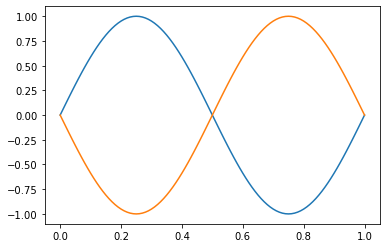

In [15]:
fn.plot(f_exact.sub(0))
fn.plot(f_exact.sub(1))

**Observations over the observation subdomain**

In [16]:
sol_forward, sol_t_forward = coupled_forward(u_ini,f_exact_dof,t_vector)
#
obs_fn = fn.Function(Un)
#obs_fn.interpolate(obs_dom_exp)
#
observations = []
observations_t = []
for idx in range(len(sol_forward)):
    observations.append(sol_forward[idx])
    observations_t.append(sol_t_forward[idx])

## BACKWARD PROBLEM

In [17]:
fn.set_log_level(30)

**Inverse problem functional** defined by
$$\inf_{f\in L^2(\mathcal{\Omega})}\left(\frac{1}{2}\int_{\Omega} f^2 \,dx + \frac{k}{2}\|y - y_{obs}\|_{L^2(\mathcal{O}\times (0,T))}^2 + \frac{k}{2}\|\partial_t y - \partial_t y_{obs}\|_{L^2(\mathcal{O}\times (0,T))}^2\right)\qquad (1.116)$$

## Gradient Descent

**Initial** $f^0$

In [18]:
f0_fn = fn.Function(Un)
f0_fn.vector()[:] = 1.0
f_old = copy(f0_fn.vector()[:])

$\displaystyle C_\sigma = \int_{0}^{T} \sigma(t)\,dx \approx \Delta t \sum_{i=1}^{N_t} dt\sigma\left(\frac{t(i) + t(i+1)}{2}\right)$

In [19]:
mid_point = (t_vector[:-1] + t_vector[1:])/2
C_sigma = dt*np.sum(sigma(mid_point))

- $f^{0}$ given. (here $F(x,t) = f(x)\sigma(t)$)
- set **tol** to a small value.
- set $\alpha$

while stop_cri > **tol** do:
- $Y^{n} = \text{forward}(f^{n},\sigma,y_0)$
- $\varphi^{n} = \text{backward}(Y^{n},Y_{\text{obs}},\varphi_0=0)$
- $\frac{\partial J}{\partial f}(f^n) = C_\sigma f^{n} - \int_{0}^{T}\sigma(t)\varphi^{n}(\cdot,t)$
- $f^{n+1} = f^{n} - \alpha \frac{\partial J}{\partial f}(f^n)$

- $\text{stop_cri} = \displaystyle\left\|\frac{\partial J}{\partial f}(f^n)\right\| = \sqrt{\int_{\Omega} \left(\frac{\partial J}{\partial f}(f^n)\right)^2}$

In [20]:
def GD_step(f_old,alpha=0.1):
    y_old, y_t_old = coupled_forward(u_ini,f_old,t_vector)
    phi_old = coupled_backward(y_old,y_t_old,observations,observations_t,t_vector,k=K)
    #
    #f_new = []
    sigma_phi_t_int = np.zeros_like(f_old)
    # time-integrals
    for idx in range(t_vector.shape[0]-1):
        sigma_phi_t_int += dt*(sigma(t_vector[idx])*phi_old[idx] + sigma(t_vector[idx+1])*phi_old[idx+1])/2   
    # gradient of J    
    grad_J = C_sigma*f_old - sigma_phi_t_int
    # GD step
    f_new = copy(f_old - alpha*grad_J)  
    # stop criteria
    grad_J_fn = fn.Function(Un)
    grad_J_fn.vector()[:] = grad_J
    difference = np.sqrt(fn.assemble(grad_J_fn**2*(fn.dx)))
    #difference = np.linalg.norm(f_new[idx] - f_old[idx])
    return f_new, difference

In [21]:
t0 = time()
for i in range(4096): # 4096 8192
    f_old, stop_cri = GD_step(f_old,alpha=ALPHA)
    print('criteria =',stop_cri)
    if (stop_cri < STOP_CRI):
        break
print('time: ',(time() - t0)/60,'[min]')        

criteria = 69.98985138545137
criteria = 40.44315515815073
criteria = 22.819319439949265
criteria = 13.543286018056342
criteria = 7.952216340767958
criteria = 4.812556250199396
criteria = 2.923241459876677
criteria = 1.8359846180033643
criteria = 1.204299421705042
criteria = 0.8614972705136733
criteria = 0.6865348660452527
criteria = 0.6035173665950909
criteria = 0.5636707456580899
criteria = 0.5423390411836145
criteria = 0.5284811130714513
criteria = 0.5176486263388109
criteria = 0.5081028560604933
criteria = 0.4991826094076861
criteria = 0.490638026528268
criteria = 0.48237502188135595
criteria = 0.4743571307351068
criteria = 0.46656867189738094
criteria = 0.4590010868490176
criteria = 0.45164803482967836
criteria = 0.4445037298517269
criteria = 0.43756244374011183
criteria = 0.430818406837613
criteria = 0.4242658278689471
criteria = 0.4178989383133038
criteria = 0.41171203229614944
criteria = 0.4056994959065595
criteria = 0.39985582675291487
criteria = 0.394175646138702
criteria = 0.

criteria = 0.07458007827328281
criteria = 0.07415705649357213
criteria = 0.07373663766217096
criteria = 0.07331880409205153
criteria = 0.07290353822787879
criteria = 0.07249082264487966
criteria = 0.07208064004774653
criteria = 0.07167297326954498
criteria = 0.07126780527064495
criteria = 0.07086511913766104
criteria = 0.07046489808240836
criteria = 0.07006712544087361
criteria = 0.06967178467219975
criteria = 0.06927885935768088
criteria = 0.06888833319977059
criteria = 0.06850019002110642
criteria = 0.0681144137635371
criteria = 0.06773098848717124
criteria = 0.06734989836943064
criteria = 0.0669711277041142
criteria = 0.06659466090047579
criteria = 0.06622048248231238
criteria = 0.06584857708705522
criteria = 0.06547892946487811
criteria = 0.06511152447781336
criteria = 0.06474634709887292
criteria = 0.06438338241118172
criteria = 0.06402261560712026
criteria = 0.06366403198747396
criteria = 0.0633076169605882
criteria = 0.06295335604153744
criteria = 0.06260123485129848
criteria = 

criteria = 0.01801245089590453
criteria = 0.017918266013799568
criteria = 0.017824588368009982
criteria = 0.017731415070584077
criteria = 0.017638743251594233
criteria = 0.017546570059002273
criteria = 0.01745489265853947
criteria = 0.017363708233580702
criteria = 0.017273013985017575
criteria = 0.017182807131137633
criteria = 0.017093084907503775
criteria = 0.017003844566829594
criteria = 0.016915083378863605
criteria = 0.016826798630264133
criteria = 0.01673898762448824
criteria = 0.016651647681669653
criteria = 0.01656477613850326
criteria = 0.016478370348131138
criteria = 0.01639242768002655
criteria = 0.016306945519881388
criteria = 0.016221921269491974
criteria = 0.016137352346649553
criteria = 0.016053236185026694
criteria = 0.01596957023406896
criteria = 0.015886351958886057
criteria = 0.015803578840141434
criteria = 0.015721248373945708
criteria = 0.015639358071752048
criteria = 0.015557905460246064
criteria = 0.015476888081245664
criteria = 0.015396303491591701
criteria = 0.0

criteria = 0.004765757242265973
criteria = 0.004741368065402632
criteria = 0.004717104597874278
criteria = 0.004692966182220272
criteria = 0.0046689521645216035
criteria = 0.004645061894381673
criteria = 0.004621294724907023
criteria = 0.004597650012686099
criteria = 0.004574127117769315
criteria = 0.004550725403651249
criteria = 0.004527444237248904
criteria = 0.004504282988882371
criteria = 0.004481241032257622
criteria = 0.004458317744444948
criteria = 0.004435512505861257
criteria = 0.004412824700249778
criteria = 0.004390253714662634
criteria = 0.004367798939441097
criteria = 0.004345459768197925
criteria = 0.004323235597796986
criteria = 0.004301125828337143
criteria = 0.004279129863132697
criteria = 0.004257247108695036
criteria = 0.004235476974715347
criteria = 0.004213818874045935
criteria = 0.004192272222683324
criteria = 0.0041708364397486895
criteria = 0.004149510947473092
criteria = 0.004128295171176884
criteria = 0.004107188539254856
criteria = 0.004086190483156648
criter

criteria = 0.0013133269896780497
criteria = 0.001306641137673502
criteria = 0.001299989398130707
criteria = 0.001293371596363599
criteria = 0.0012867875585873354
criteria = 0.0012802371119124468
criteria = 0.001273720084342029
criteria = 0.0012672363047655291
criteria = 0.0012607856029541217
criteria = 0.0012543678095573753
criteria = 0.0012479827560968545
criteria = 0.0012416302749633389
criteria = 0.0012353101994109152
criteria = 0.001229022363553078
criteria = 0.0012227666023584983
criteria = 0.0012165427516457007
criteria = 0.0012103506480796364
criteria = 0.0012041901291663015
criteria = 0.0011980610332492578
criteria = 0.001191963199504568
criteria = 0.0011858964679367313
criteria = 0.001179860679374464
criteria = 0.001173855675465746
criteria = 0.0011678812986745883
criteria = 0.001161937392276225
criteria = 0.001156023800352747
criteria = 0.0011501403677888493
criteria = 0.0011442869402682034
criteria = 0.0011384633642687765
criteria = 0.0011326694870587542
criteria = 0.0011269

criteria = 0.0003690607469375871
criteria = 0.00036718601740484404
criteria = 0.00036532082451294965
criteria = 0.0003634651196710134
criteria = 0.0003616188545368056
criteria = 0.00035978198101410246
criteria = 0.000357954451252578
criteria = 0.00035613621764669044
criteria = 0.000354327232833474
criteria = 0.0003525274496914773
criteria = 0.00035073682134068176
criteria = 0.00034895530113997035
criteria = 0.0003471828426857785
criteria = 0.0003454193998125708
criteria = 0.0003436649265897511
criteria = 0.00034191937732117077
criteria = 0.00034018270654444547
criteria = 0.0003384548690290776
criteria = 0.0003367358197748574
criteria = 0.0003350255140124218
criteria = 0.0003333239071996486
criteria = 0.00033163095502325473
criteria = 0.0003299466133945666
criteria = 0.00032827083845153826
criteria = 0.000326603586554548
criteria = 0.0003249448142876395
criteria = 0.0003232944784563356
criteria = 0.00032165253608612825
criteria = 0.00032001894442295633
criteria = 0.0003183936609295957
c

criteria = 0.00010609326423434934
criteria = 0.00010555524664541107
criteria = 0.00010501996100757566
criteria = 0.00010448739342967246
criteria = 0.00010395753009148043
criteria = 0.0001034303572429874
criteria = 0.00010290586120425571
criteria = 0.00010238402836534084
criteria = 0.00010186484518469317
criteria = 0.00010134829819086427
criteria = 0.00010083437397987377
criteria = 0.00010032305921699195
criteria = 9.9814340634672e-05
criteria = 9.930820503311857e-05
criteria = 9.880463927998368e-05
criteria = 9.830363030955853e-05
criteria = 9.780516512245284e-05
criteria = 9.730923078597343e-05
criteria = 9.681581443279619e-05
criteria = 9.63249032613985e-05
criteria = 9.58364845352299e-05
criteria = 9.53505455830019e-05
criteria = 9.486707379709865e-05
criteria = 9.438605663514196e-05
criteria = 9.390748161762848e-05
criteria = 9.343133632905354e-05
criteria = 9.295760841754703e-05
criteria = 9.248628559328248e-05
criteria = 9.201735562951783e-05
criteria = 9.155080636142117e-05
crit

criteria = 3.0099017899770483e-05
criteria = 2.9946626986480825e-05
criteria = 2.9795008587450248e-05
criteria = 2.9644158781323602e-05
criteria = 2.9494073667232178e-05
criteria = 2.9344749363305663e-05
criteria = 2.919618200788076e-05
criteria = 2.9048367758998097e-05
criteria = 2.890130279427294e-05
criteria = 2.8754983310003534e-05
criteria = 2.8609405522887368e-05
criteria = 2.8464565667842995e-05
criteria = 2.8320459999863416e-05
criteria = 2.8177084792262395e-05
criteria = 2.80344363378273e-05
criteria = 2.789251094753628e-05
criteria = 2.7751304951641005e-05
criteria = 2.761081469904223e-05
criteria = 2.7471036556826436e-05
criteria = 2.733196691115938e-05
criteria = 2.719360216578511e-05
criteria = 2.705593874316626e-05
criteria = 2.691897308418797e-05
criteria = 2.678270164724225e-05
criteria = 2.664712090905633e-05
criteria = 2.6512227364636226e-05
criteria = 2.6378017525775174e-05
criteria = 2.6244487923097553e-05
criteria = 2.6111635104002247e-05
criteria = 2.5979455633898

In [22]:
np.save('data/source_recons_'+label_str,f_old)
np.savez('data/parameters_'+label_str,
         f_old=f_old,
         f_exact_dof = f_exact_dof,
         Ne=Ne,
         t_vector=t_vector,
         sigma_vector = sigma(t_vector),
         nu=nu,
         gamma1=gamma1,
         gamma2=gamma2,
         K        = K,
         ALPHA    = ALPHA,
         STOP_CRI = STOP_CRI,
         OBS_DOM = OBS_DOM,
        )

**$|y - y_{obs}| + |\partial_t y - \partial_t y_{obs}|$**

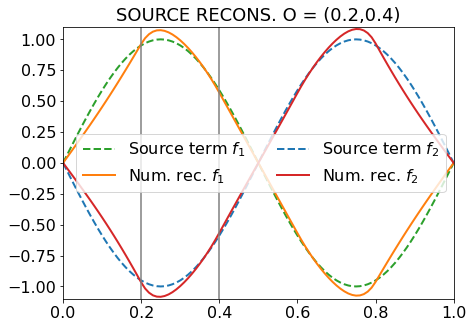

In [23]:
f1_obs, f2_obs = f_exact.split()
#
f_rec = fn.Function(Un)
f_rec.vector()[:] = f_old
f1_rec, f2_rec = f_rec.split()
#
plt.figure(figsize=(7,5))
fn.plot(f1_obs,label='Source term $f_1$',
        color='tab:green',
         linestyle='--',
         marker=None,
         linewidth=2.0,
       )
fn.plot(f1_rec,label='Num. rec. $f_1$',
        color='tab:orange',
         linestyle='-',
         marker=None,
         linewidth=2.0,
       )
fn.plot(f2_obs,label='Source term $f_2$',
        color='tab:blue',
         linestyle='--',
         marker=None,
         linewidth=2.0,
       )
fn.plot(f2_rec,label='Num. rec. $f_2$',
        color='tab:red',
         linestyle='-',
         marker=None,
         linewidth=2.0,
       )
#
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlim(0.,1.)
#plt.ylim(None,2.7)
plt.axvline(OBS_DOM[0],color='tab:gray')
plt.axvline(OBS_DOM[1],color='tab:gray')
plt.title('SOURCE RECONS. O = (%1.1f,%1.1f)'%(OBS_DOM[0],OBS_DOM[1]),fontsize=18)
plt.legend(ncol=2,fontsize=16)
#
plt.show()
#title_str = 'IP_num_rec_2_sub_dom_(%1.1f,%1.1f)'%(OBS_DOM[0],OBS_DOM[1])
#plt.savefig('Images/'+title_str+'.png', dpi=600, facecolor=None, edgecolor=None,
#            orientation='portrait', format='png',transparent=True, 
#            bbox_inches='tight', pad_inches=0.1, metadata=None)

**Uniqueness sanity check**

In [24]:
sol_check, sol_t_check = coupled_forward(u_ini,f_old,t_vector)

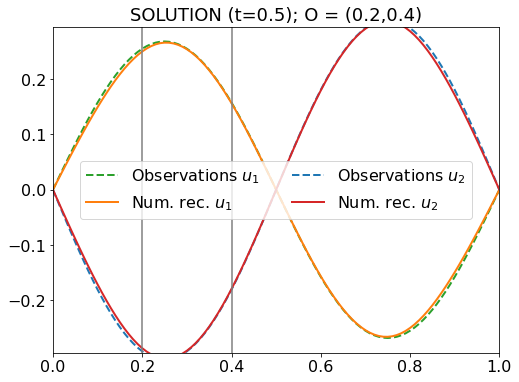

In [25]:
idx = -1
u_obs = fn.Function(Un)
u_obs.vector()[:] = observations[idx]
#
u_rec = fn.Function(Un)
u_rec.vector()[:] = sol_check[idx]
#
plt.figure(figsize=(8,6))
fn.plot(u_obs.sub(0),label='Observations $u_1$',
        color='tab:green',
         linestyle='--',
         marker=None,
         linewidth=2.0,
       )
fn.plot(u_rec.sub(0),label='Num. rec. $u_1$',
        color='tab:orange',
         linestyle='-',
         marker=None,
         linewidth=2.0,
       )
fn.plot(u_obs.sub(1),label='Observations $u_2$',
        color='tab:blue',
         linestyle='--',
         marker=None,
         linewidth=2.0,
       )
fn.plot(u_rec.sub(1),label='Num. rec. $u_2$',
        color='tab:red',
         linestyle='-',
         marker=None,
         linewidth=2.0,
       )
#
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlim(0.,1.)
#plt.ylim(None,2.7)
plt.axvline(OBS_DOM[0],color='tab:gray')
plt.axvline(OBS_DOM[1],color='tab:gray')
#
plt.title('SOLUTION (t=%1.1f); O = (%1.1f,%1.1f)'%(t_vector[idx],OBS_DOM[0],OBS_DOM[1]),fontsize=18)
plt.legend(ncol=2,fontsize=16)
plt.show()

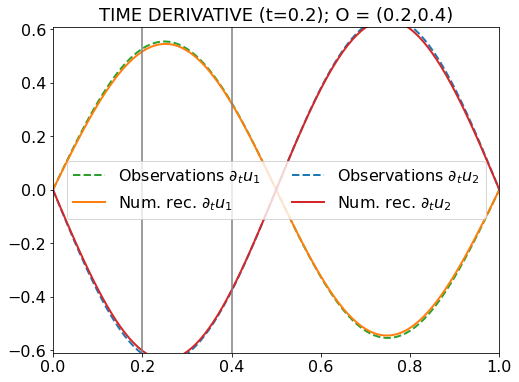

In [26]:
idx = 20
u_obs = fn.Function(Un)
u_obs.vector()[:] = observations_t[idx]
#
u_rec = fn.Function(Un)
u_rec.vector()[:] = sol_t_check[idx]
#
plt.figure(figsize=(8,6))
fn.plot(u_obs.sub(0),label='Observations $\partial_t u_1$',
        color='tab:green',
         linestyle='--',
         marker=None,
         linewidth=2.0,
       )
fn.plot(u_rec.sub(0),label='Num. rec. $\partial_t u_1$',
        color='tab:orange',
         linestyle='-',
         marker=None,
         linewidth=2.0,
       )
fn.plot(u_obs.sub(1),label='Observations $\partial_t u_2$',
        color='tab:blue',
         linestyle='--',
         marker=None,
         linewidth=2.0,
       )
fn.plot(u_rec.sub(1),label='Num. rec. $\partial_t u_2$',
        color='tab:red',
         linestyle='-',
         marker=None,
         linewidth=2.0,
       )
#
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlim(0.,1.)
#plt.ylim(None,2.7)
plt.axvline(OBS_DOM[0],color='tab:gray')
plt.axvline(OBS_DOM[1],color='tab:gray')
#
plt.title('TIME DERIVATIVE (t=%1.1f); O = (%1.1f,%1.1f)'%(t_vector[idx],OBS_DOM[0],OBS_DOM[1]),fontsize=18)
plt.legend(ncol=2,fontsize=16)